In [1]:
# Imports & Setup

import sys
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

PROJECT_FOLDER = '/home/ricardo/coding/data-science/projects/predict_value_change_from_fm_data/'

sys.path.insert(0, PROJECT_FOLDER)

from utils import POSITION_MAPPING, name_to_id

plt.rcParams["figure.figsize"] = (20,10)

warnings.filterwarnings('ignore')

In [2]:
# Import datasets

fm20_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/datafm20.csv")
transfermarkt_players_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/players.csv")
transfermarkt_valuations_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/player_valuations.csv")

In [3]:
# Prepare dataset - merge fm20_df and less_28_players

# Use only players with less than 28 yo

transfermarkt_base_players_df = transfermarkt_players_dataset [:]
transfermarkt_base_players_df.query("last_season >= 2021 & date_of_birth >= '1992-01-01' & position != 'Goalkeeper'", inplace=True)
transfermarkt_base_players_df.sort_values(by='market_value_in_gbp', ascending=False, inplace=True)

fm20_base_players_df = fm20_dataset.query("Age <= 27 & `Best Pos` != 'GK'")
fm20_base_players_df.sort_values(by='Value', ascending=False, inplace=True)

In [4]:
# Map country_of_citizenship (Transfermarkt) to country codes (FM20)

fm20_name_nation_mapping = fm20_dataset.groupby('Nation').head()[['Name', 'Nation']]
fm20_name_nation_mapping['Transfermarkt_Name'] = fm20_name_nation_mapping['Name'].apply(name_to_id).apply(lambda x: x.replace('-scaron-', 's'))

transfermarkt_name_nation_mapping = transfermarkt_base_players_df[['name', 'country_of_citizenship']]

player_nationalities_mapping = fm20_name_nation_mapping.merge(transfermarkt_name_nation_mapping, left_on='Transfermarkt_Name', right_on='name')
player_nationalities_mapping.drop_duplicates(subset='Nation', inplace=True)

fm20_base_players_df = fm20_base_players_df.merge(player_nationalities_mapping[['Nation', 'country_of_citizenship']], on='Nation')

In [5]:
# Map position (Transfermarkt) to Best Pos (FM20)


transfermarkt_base_players_df['FM_Pos'] = transfermarkt_base_players_df['position'].apply(lambda x: x[0])

fm20_base_players_df['Transfermarkt_Pos'] = fm20_base_players_df['Best Pos'].map(POSITION_MAPPING)

In [6]:
# Map name (Transfermarkt) to Name (FM20)

fm20_base_players_df['Transfermarkt_Name'] = fm20_base_players_df['Name'].apply(name_to_id).apply(lambda x: x.replace('-scaron-', 's'))

In [7]:
# Merge dataframes

transfermarkt_fm20_merged_df = fm20_base_players_df.merge(transfermarkt_base_players_df, left_on=['Transfermarkt_Name', 'country_of_citizenship', 'Transfermarkt_Pos'], right_on=['name', 'country_of_citizenship', 'FM_Pos'])

transfermarkt_fm20_merged_df.drop_duplicates(subset=['Transfermarkt_Name', 'country_of_citizenship', 'FM_Pos'], inplace=True)

In [8]:
# Insert target values (valuation now vs valuations 2020)

transfermarkt_fm20_merged_df['value_2022'] = transfermarkt_fm20_merged_df['market_value_in_gbp']

player_values_2020 = transfermarkt_valuations_dataset.query("date >= '2019-07-01' & date <= '2020-12-31'").sort_values(by='date', ascending=True).drop_duplicates(subset='player_id')

player_values_2020['value_2020'] = player_values_2020['market_value']

players_with_values = transfermarkt_fm20_merged_df.merge(player_values_2020, on='player_id')

players_with_values['value_diff'] = players_with_values['value_2022'] - players_with_values['value_2020']

<AxesSubplot:>

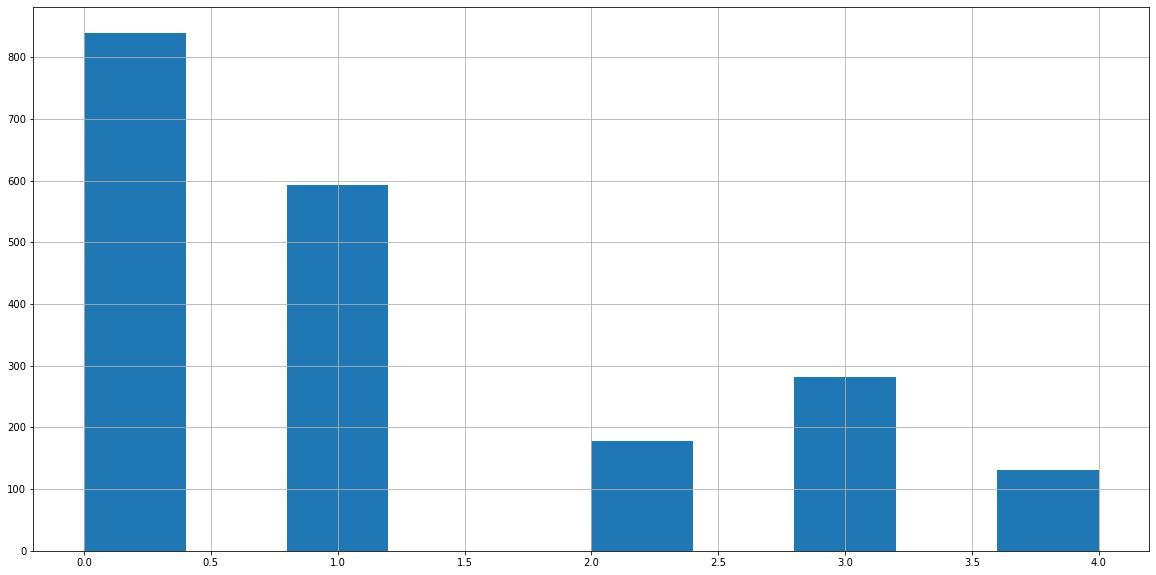

In [9]:
# Prepare df for stratify


value_bins = [-np.inf, 0, 1000000, 2500000, 10000000, np.inf]

players_with_values['value_cat'] = pd.cut(players_with_values["value_diff"], bins=value_bins, labels=range(len(value_bins)-1))

players_with_values['value_cat'].hist()

In [10]:
# Create test set

from sklearn.model_selection import train_test_split

players_for_analysis = players_with_values[:]

players_for_analysis.dropna(subset=['value_cat'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(players_for_analysis, players_for_analysis['value_cat'], test_size=0.2, random_state=42, stratify=players_for_analysis['value_cat'])

In [11]:
# Revert to clean training set

players_v1 = x_train.drop('value_cat', axis=1)
players_labels_v1 = x_train['value_cat'].copy()

In [12]:
# Custom Nation transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
        nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        max_rank = nation_encoder['rank'].max() + 1
        X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        X.drop('Nation', axis=1, inplace=True)
        return X

In [13]:
# Custom Attributes transformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from utils import apply_mean_attribute_list, PLAYER_ATTR

class AttributeMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        physical_attr = ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat']
        mental_attr = ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg']
        apply_mean_attribute_list(X, 'M+P', physical_attr + mental_attr)
        X['M+P'] = X['M+P'] / 20
        X.drop(PLAYER_ATTR, axis=1, inplace=True)
        return X


In [14]:
# Custom Based transformer

from sklearn.base import BaseEstimator, TransformerMixin

class BasedToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        based_encoder = players_with_values.groupby('Based').sum().rank(ascending=True, method='first')
        max_rank = based_encoder['value_2020'].max()
        X['Based_rank'] = (X['Based'].map(based_encoder['value_2020']).fillna(max_rank) / max_rank)
        X.drop('Based', axis=1, inplace=True)
        return X

In [15]:
# Using transformation pipelines

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils import PLAYER_ATTR

players = x_train.drop('Value', axis=1)

features_v1 = {
    'att': (PLAYER_ATTR, ['M+P']),
    'num': (PLAYER_ATTR + ['Age'], None),
    'cat': (['Preferred Foot', 'Best Pos'], [f'Foot {_}' for _ in range(5)] + [f'Pos {_}' for _ in range(13)]),
    'nat': (['Nation'], None),
    'bas': (['Based'], None)
}

feature_labels_v1 = list(np.concatenate([f[1] if f[1] is not None else f[0] for k, f in features_v1.items()]).flat)

full_pipeline_v1 = ColumnTransformer([
    ("att", AttributeMerger(), features_v1['att'][0]),
    ("num", StandardScaler(), features_v1['num'][0]),
    ("cat", OneHotEncoder(), features_v1['cat'][0]),
    ("nat", NationToRank(), features_v1['nat'][0]),
    ("bas", BasedToRank(), features_v1['bas'][0])
])

players_prepared_v1 = full_pipeline_v1.fit_transform(players)

In [16]:
# Select and train model
## RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

value_predictor_v1 = RandomForestClassifier(max_depth=None, n_estimators = 100, random_state = 42)
value_predictor_v1.fit(players_prepared_v1, players_labels_v1)

RandomForestClassifier(random_state=42)

In [17]:
# Error analysis

from sklearn.model_selection import cross_val_predict

value_predictions_v1 = cross_val_predict(value_predictor_v1, players_prepared_v1, players_labels_v1, cv=5)

<AxesSubplot:>

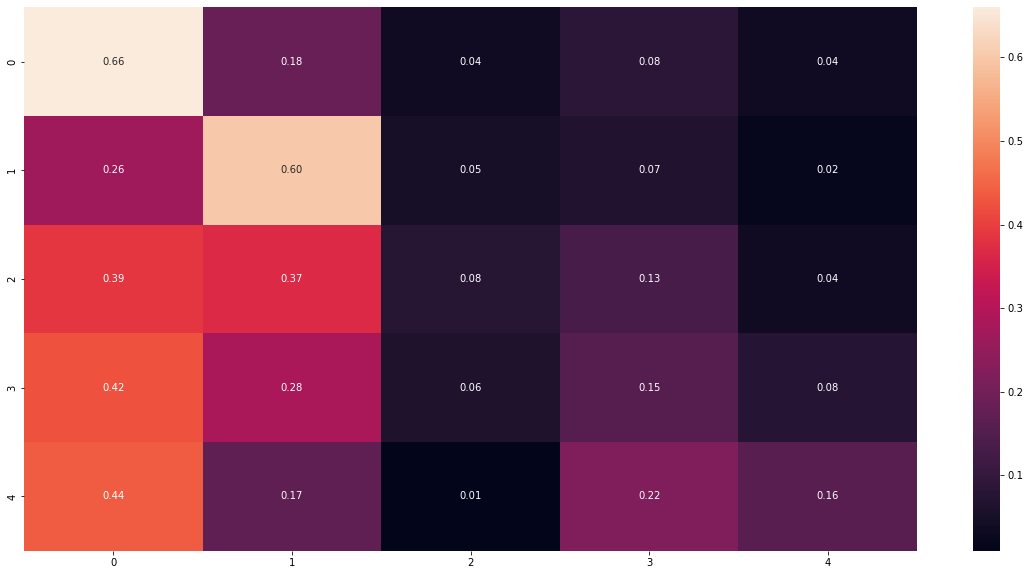

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(players_labels_v1, value_predictions_v1)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

<BarContainer object of 3 artists>

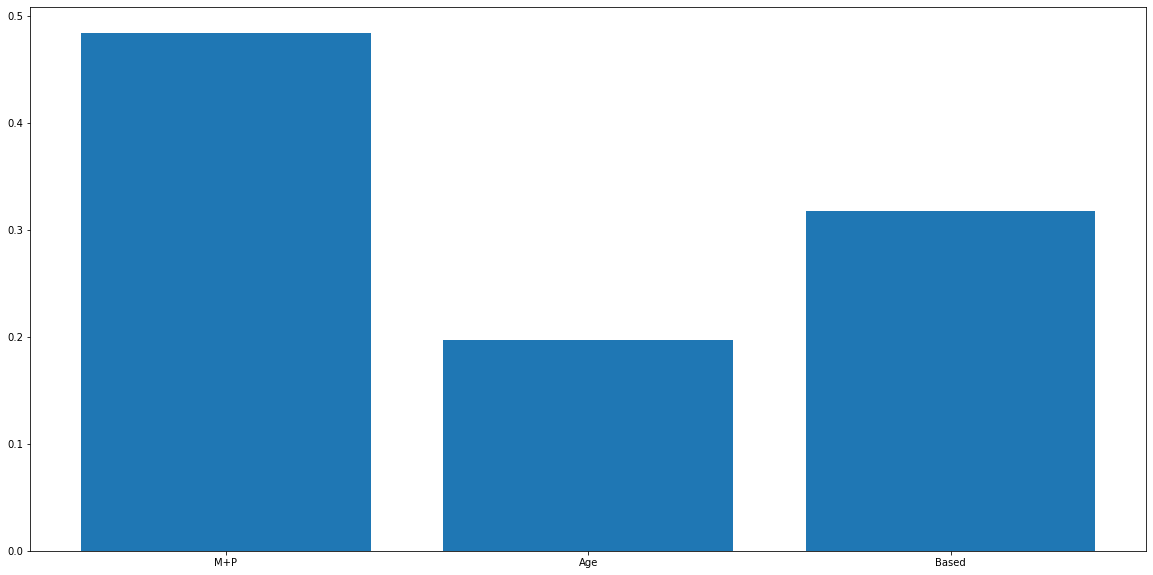

In [19]:
plt.bar(feature_labels_v1, value_predictor_v1.feature_importances_)

<AxesSubplot:>

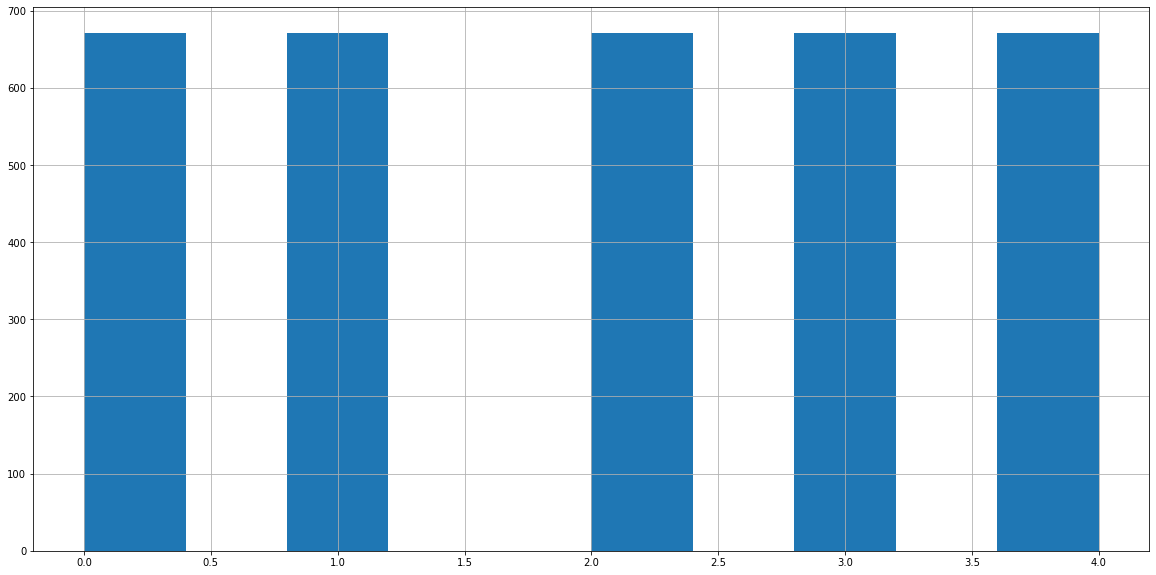

In [20]:
# Oversample minority classes
from imblearn.over_sampling import SMOTE
players_prepared_over_v1, players_labels_over_v1 = SMOTE().fit_resample(players_prepared_v1, players_labels_v1)

players_labels_over_v1.hist()

In [21]:
# Train again with oversampled data

from sklearn.ensemble import RandomForestClassifier

value_predictor_v2 = RandomForestClassifier(max_depth=None, n_estimators = 100, random_state = 42)
value_predictor_v2.fit(players_prepared_over_v1, players_labels_over_v1)

RandomForestClassifier(random_state=42)

In [22]:
# Error analysis

from sklearn.model_selection import cross_val_predict

value_predictions_v2 = cross_val_predict(value_predictor_v2, players_prepared_over_v1, players_labels_over_v1, cv=5)

<AxesSubplot:>

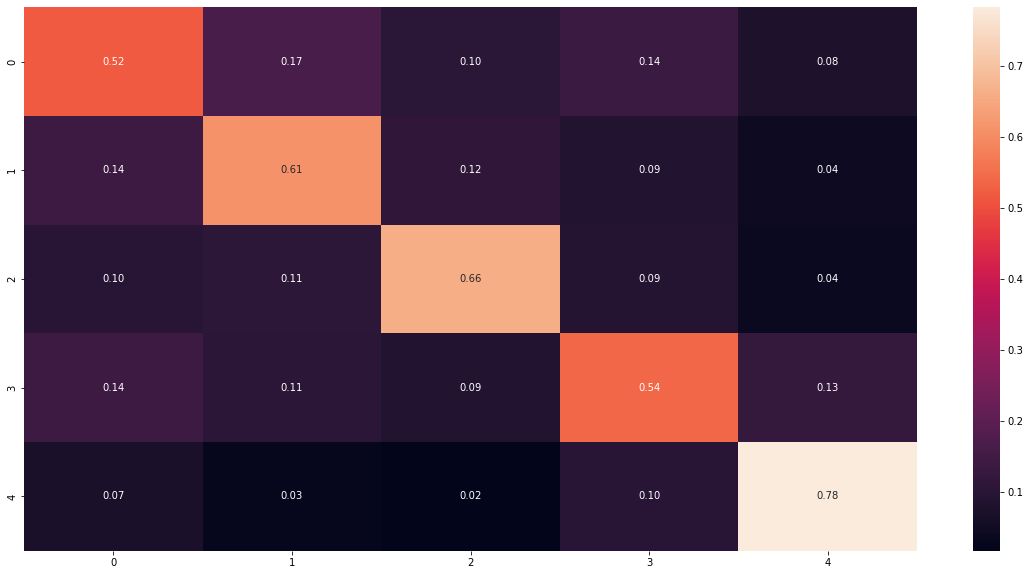

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(players_labels_over_v1, value_predictions_v2)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

In [24]:
# Save promissing model

import joblib
joblib.dump(value_predictor_v2, PROJECT_FOLDER + "models/rf_value_predictor.pkl")

['/home/ricardo/coding/data-science/projects/predict_value_change_from_fm_data/models/rf_value_predictor.pkl']

In [25]:
# Prepare test values for analysis

test_players_prepared = full_pipeline_v1.fit_transform(x_test)
test_players_labels = y_test

In [26]:
# Predict test values

value_predictor_v2.predict(test_players_prepared[0].reshape(1, -1))

test_value_predictions_v2 = cross_val_predict(value_predictor_v2, test_players_prepared, test_players_labels, cv=5)

<AxesSubplot:>

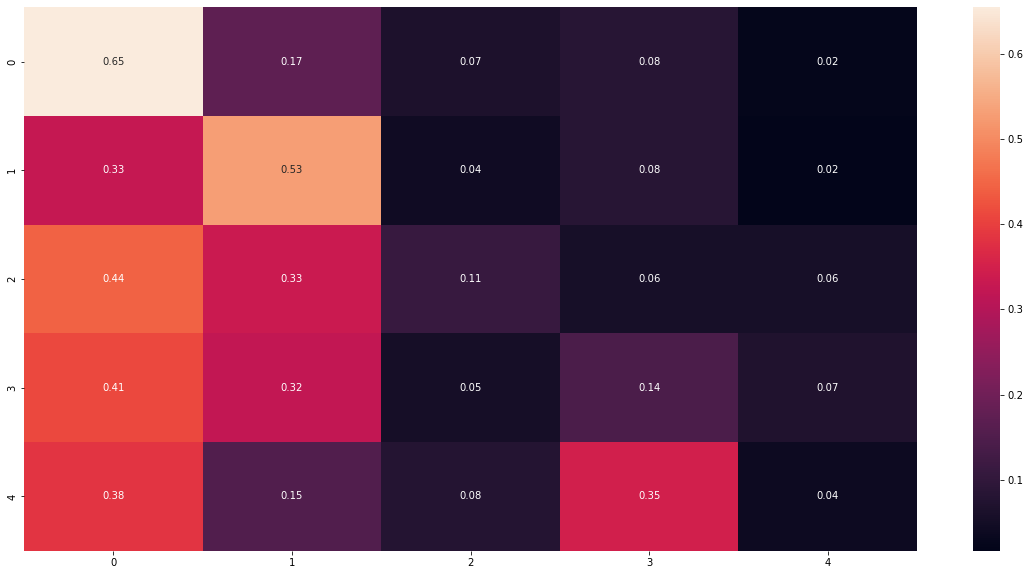

In [27]:
# Test values confusion matrix

conf_mx = confusion_matrix(test_players_labels, test_value_predictions_v2)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_value_predictions_v2, value_predictor_v2.predict_proba(test_players_prepared)[:, 4])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

ValueError: multiclass format is not supported

In [ ]:
# Select most relevant features
# from sklearn.base import clone

# features_v3 = ['Cmp', 'Tec', 'Pac', 'Bal', 'Age', 'M+P', 'Based']
# full_pipeline_v3 = full_pipeline.clone()
# full_pipeline_v3['num'] = features_v3


AttributeError: 'ColumnTransformer' object has no attribute 'clone'